In [122]:
# Import Necessary Libraries
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM
from sklearn.preprocessing import MinMaxScaler
import warnings


In [123]:

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set Up Global Variables
# Constants
INITIAL_CAPITAL = 100000  # Starting capital in USD
TRANSACTION_COST = 0.001  # 0.1% per trade
POSITION_SIZE = 0.1       # 10% of available capital per trade
RISK_FREE_RATE = 0.01     # 1% annual risk-free rate


In [124]:

# 1. Download and Prepare Stock Data
def download_stock_data(ticker, start_date, end_date):
    """
    Downloads historical stock data from Yahoo Finance.
    """
    data = yf.download(ticker, start=start_date, end=end_date)
    # Flatten MultiIndex columns if necessary
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.get_level_values(0)
    data.dropna(inplace=True)
    data.reset_index(drop=False, inplace=True)
    return data

# 2. Calculate Technical Indicators
def calculate_rsi(data, period=14):
    """
    Calculates the Relative Strength Index (RSI) for the given data.
    """
    delta = data['Close'].diff()
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)
    # Use exponential moving average
    gain = up.ewm(alpha=1/period, min_periods=period).mean()
    loss = down.ewm(alpha=1/period, min_periods=period).mean()
    RS = gain / loss
    data['RSI'] = 100 - (100 / (1 + RS))
    return data


In [125]:

# 3. Implement Trading Strategies

# 3.1. Base Trading Class
class TradingStrategy:
    """
    Base class for trading strategies.
    """
    def __init__(self, data):
        self.data = data.copy()
        self.initial_capital = INITIAL_CAPITAL
        self.capital = INITIAL_CAPITAL
        self.position = 0
        self.cash = INITIAL_CAPITAL
        self.holdings = 0
        self.total = INITIAL_CAPITAL
        self.trade_log = []
        self.portfolio_values = []
        
    def execute_trade(self, index, signal, price):
        """
        Executes a trade based on the signal.
        """
        pass
        
    def calculate_performance(self):
        """
        Calculates performance metrics of the strategy.
        """
        pass


In [126]:

# 3.2. RSI-Only Trading Strategy
class RSIStrategy(TradingStrategy):
    """
    Trading strategy based on RSI signals.
    """
    def generate_signals(self):
        """
        Generates trading signals based on RSI.
        """
        self.data['Signal'] = 0
        self.data.loc[self.data['RSI'] < 30, 'Signal'] = 1   # Buy signal
        self.data.loc[self.data['RSI'] > 70, 'Signal'] = -1  # Sell signal
        
    def execute_trade(self, index, signal, price):
        date = self.data.at[index, 'Date']
        if signal == 1 and self.position == 0:
            # Buy
            allocation = self.cash * POSITION_SIZE
            shares = (allocation * (1 - TRANSACTION_COST)) // price
            if shares > 0:
                cost = shares * price * (1 + TRANSACTION_COST)
                self.cash -= cost
                self.position += shares
                self.trade_log.append({
                    'Date': date,
                    'Type': 'Buy',
                    'Price': price,
                    'Shares': shares,
                    'Cash': self.cash,
                    'Position': self.position
                })
        elif signal == -1 and self.position > 0:
            # Sell
            proceeds = self.position * price * (1 - TRANSACTION_COST)
            self.cash += proceeds
            self.trade_log.append({
                'Date': date,
                'Type': 'Sell',
                'Price': price,
                'Shares': self.position,
                'Cash': self.cash,
                'Position': 0
            })
            self.position = 0
        self.holdings = self.position * price
        self.total = self.cash + self.holdings
        self.portfolio_values.append({'Date': date, 'Total': self.total})
        
    def backtest(self):
        """
        Runs the backtest of the RSI strategy.
        """
        self.generate_signals()
        for i in range(len(self.data)):
            signal = self.data.at[i, 'Signal']
            price = self.data.at[i, 'Close']
            self.execute_trade(i, signal, price)
        # Close any open positions at the end
        if self.position > 0:
            self.execute_trade(len(self.data) - 1, -1, self.data.at[len(self.data) - 1, 'Close'])
        
    def calculate_performance(self):
        portfolio_df = pd.DataFrame(self.portfolio_values)
        portfolio_df.set_index('Date', inplace=True)
        returns = portfolio_df['Total'].pct_change().dropna()
        
        # Calculate CAGR
        total_days = (portfolio_df.index[-1] - portfolio_df.index[0]).days
        years = total_days / 365.25
        cagr = (portfolio_df['Total'][-1] / portfolio_df['Total'][0]) ** (1/years) -1
        
        # Calculate annualized volatility
        annual_volatility = returns.std() * np.sqrt(252)
        
        # Calculate Sharpe Ratio
        sharpe_ratio = (returns.mean() * 252 - RISK_FREE_RATE) / (returns.std() * np.sqrt(252))
        
        # Calculate Max Drawdown
        cumulative_returns = (1 + returns).cumprod()
        peak = cumulative_returns.expanding(min_periods=1).max()
        drawdown = (cumulative_returns - peak) / peak
        max_drawdown = drawdown.min()
        
        performance = {
            'CAGR': cagr,
            'Annual Volatility': annual_volatility,
            'Sharpe Ratio': sharpe_ratio,
            'Max Drawdown': max_drawdown,
            'Win Rate': self.calculate_win_rate(),
            'Final Portfolio Value': self.total
        }
        return performance
        
    def calculate_win_rate(self):
        trade_df = pd.DataFrame(self.trade_log)
        profits = []
        for i in range(1, len(trade_df), 2):
            buy_price = trade_df.at[i - 1, 'Price']
            sell_price = trade_df.at[i, 'Price']
            shares = trade_df.at[i, 'Shares']
            profit = (sell_price - buy_price) * shares - (buy_price + sell_price) * shares * TRANSACTION_COST
            profits.append(profit)
        wins = len([p for p in profits if p > 0])
        total = len(profits)
        win_rate = wins / total if total > 0 else 0
        return win_rate


In [127]:

# 3.3. Decision Tree-Based Trading Strategy
class DecisionTreeStrategy(TradingStrategy):
    """
    Trading strategy based on Decision Tree predictions.
    """
    def prepare_data(self):
        """
        Prepares data for model training and prediction.
        """
        # Create features and target
        self.data['Future Close'] = self.data['Close'].shift(-1)
        self.data.dropna(inplace=True)
        self.data['Signal_DT'] = np.where(self.data['Future Close'] > self.data['Close'], 1, -1)
        
        # Features: Only RSI
        self.features = ['RSI']
        self.X = self.data[self.features]
        self.y = self.data['Signal_DT']
        
    def train_model(self):
        """
        Trains the Decision Tree model.
        """
        split = int(len(self.data) * 0.8)
        X_train = self.X.iloc[:split]
        y_train = self.y.iloc[:split]
        X_test = self.X.iloc[split:]
        self.X_test_dates = self.data['Date'].iloc[split:].reset_index(drop=True)
        
        self.model = DecisionTreeClassifier(random_state=42)
        self.model.fit(X_train, y_train)
        self.predictions = self.model.predict(X_test)
        self.X_test = X_test.reset_index(drop=True)
        
    def execute_trade(self, index, signal, price):
        date = self.X_test_dates.at[index]
        if signal == 1 and self.position == 0:
            # Buy
            allocation = self.cash * POSITION_SIZE
            shares = (allocation * (1 - TRANSACTION_COST)) // price
            if shares > 0:
                cost = shares * price * (1 + TRANSACTION_COST)
                self.cash -= cost
                self.position += shares
                self.trade_log.append({
                    'Date': date,
                    'Type': 'Buy',
                    'Price': price,
                    'Shares': shares,
                    'Cash': self.cash,
                    'Position': self.position
                })
        elif signal == -1 and self.position > 0:
            # Sell
            proceeds = self.position * price * (1 - TRANSACTION_COST)
            self.cash += proceeds
            self.trade_log.append({
                'Date': date,
                'Type': 'Sell',
                'Price': price,
                'Shares': self.position,
                'Cash': self.cash,
                'Position': 0
            })
            self.position = 0
        self.holdings = self.position * price
        self.total = self.cash + self.holdings
        self.portfolio_values.append({'Date': date, 'Total': self.total})
        
    def backtest(self):
        """
        Runs the backtest of the Decision Tree strategy.
        """
        self.prepare_data()
        self.train_model()
        for i in range(len(self.predictions)):
            signal = self.predictions[i]
            price = self.data.iloc[i + int(len(self.data) * 0.8)]['Close']
            self.execute_trade(i, signal, price)
        # Close any open positions at the end
        if self.position > 0:
            self.execute_trade(len(self.predictions) - 1, -1, self.data.iloc[-1]['Close'])
        
    def calculate_performance(self):
        portfolio_df = pd.DataFrame(self.portfolio_values)
        portfolio_df.set_index('Date', inplace=True)
        returns = portfolio_df['Total'].pct_change().dropna()
        
        # Calculate CAGR
        total_days = (portfolio_df.index[-1] - portfolio_df.index[0]).days
        years = total_days / 365.25
        cagr = (portfolio_df['Total'][-1] / portfolio_df['Total'][0]) ** (1/years) - 1
        
        # Calculate annualized volatility
        annual_volatility = returns.std() * np.sqrt(252)
        
        # Calculate Sharpe Ratio
        sharpe_ratio = (returns.mean() * 252 - RISK_FREE_RATE) / (returns.std() * np.sqrt(252))
        
        # Calculate Max Drawdown
        cumulative_returns = (1 + returns).cumprod()
        peak = cumulative_returns.expanding(min_periods=1).max()
        drawdown = (cumulative_returns - peak) / peak
        max_drawdown = drawdown.min()
        
        performance = {
            'CAGR': cagr,
            'Annual Volatility': annual_volatility,
            'Sharpe Ratio': sharpe_ratio,
            'Max Drawdown': max_drawdown,
            'Win Rate': self.calculate_win_rate(),
            'Final Portfolio Value': self.total
        }
        return performance
        
    def calculate_win_rate(self):
        trade_df = pd.DataFrame(self.trade_log)
        profits = []
        for i in range(1, len(trade_df), 2):
            buy_price = trade_df.at[i - 1, 'Price']
            sell_price = trade_df.at[i, 'Price']
            shares = trade_df.at[i, 'Shares']
            profit = (sell_price - buy_price) * shares - (buy_price + sell_price) * shares * TRANSACTION_COST
            profits.append(profit)
        wins = len([p for p in profits if p > 0])
        total = len(profits)
        win_rate = wins / total if total > 0 else 0
        return win_rate


In [128]:

# 3.4. Random Forest-Based Trading Strategy
class RandomForestStrategy(TradingStrategy):
    """
    Trading strategy based on Random Forest predictions.
    """
    def prepare_data(self):
        """
        Prepares data for model training and prediction.
        """
        # Create features and target
        self.data['Future Close'] = self.data['Close'].shift(-1)
        self.data.dropna(inplace=True)
        self.data['Signal_RF'] = np.where(self.data['Future Close'] > self.data['Close'], 1, -1)
        
        # Features: Only RSI
        self.features = ['RSI']
        self.X = self.data[self.features]
        self.y = self.data['Signal_RF']
        
    def train_model(self):
        """
        Trains the Random Forest model.
        """
        split = int(len(self.data) * 0.8)
        X_train = self.X.iloc[:split]
        y_train = self.y.iloc[:split]
        X_test = self.X.iloc[split:]
        self.X_test_dates = self.data['Date'].iloc[split:].reset_index(drop=True)
        
        self.model = RandomForestClassifier(n_estimators=100, random_state=42)
        self.model.fit(X_train, y_train)
        self.predictions = self.model.predict(X_test)
        self.X_test = X_test.reset_index(drop=True)
        
    def execute_trade(self, index, signal, price):
        date = self.X_test_dates.at[index]
        if signal == 1 and self.position == 0:
            # Buy
            allocation = self.cash * POSITION_SIZE
            shares = (allocation * (1 - TRANSACTION_COST)) // price
            if shares > 0:
                cost = shares * price * (1 + TRANSACTION_COST)
                self.cash -= cost
                self.position += shares
                self.trade_log.append({
                    'Date': date,
                    'Type': 'Buy',
                    'Price': price,
                    'Shares': shares,
                    'Cash': self.cash,
                    'Position': self.position
                })
        elif signal == -1 and self.position > 0:
            # Sell
            proceeds = self.position * price * (1 - TRANSACTION_COST)
            self.cash += proceeds
            self.trade_log.append({
                'Date': date,
                'Type': 'Sell',
                'Price': price,
                'Shares': self.position,
                'Cash': self.cash,
                'Position': 0
            })
            self.position = 0
        self.holdings = self.position * price
        self.total = self.cash + self.holdings
        self.portfolio_values.append({'Date': date, 'Total': self.total})
        
    def backtest(self):
        """
        Runs the backtest of the Random Forest strategy.
        """
        self.prepare_data()
        self.train_model()
        for i in range(len(self.predictions)):
            signal = self.predictions[i]
            price = self.data.iloc[i + int(len(self.data) * 0.8)]['Close']
            self.execute_trade(i, signal, price)
        # Close any open positions at the end
        if self.position > 0:
            self.execute_trade(len(self.predictions) - 1, -1, self.data.iloc[-1]['Close'])
        
    def calculate_performance(self):
        portfolio_df = pd.DataFrame(self.portfolio_values)
        portfolio_df.set_index('Date', inplace=True)
        returns = portfolio_df['Total'].pct_change().dropna()
        
        # Calculate CAGR
        total_days = (portfolio_df.index[-1] - portfolio_df.index[0]).days
        years = total_days / 365.25
        cagr = (portfolio_df['Total'][-1] / portfolio_df['Total'][0]) ** (1/years) - 1
        
        # Calculate annualized volatility
        annual_volatility = returns.std() * np.sqrt(252)
        
        # Calculate Sharpe Ratio
        sharpe_ratio = (returns.mean() * 252 - RISK_FREE_RATE) / (returns.std() * np.sqrt(252))
        
        # Calculate Max Drawdown
        cumulative_returns = (1 + returns).cumprod()
        peak = cumulative_returns.expanding(min_periods=1).max()
        drawdown = (cumulative_returns - peak) / peak
        max_drawdown = drawdown.min()
        
        performance = {
            'CAGR': cagr,
            'Annual Volatility': annual_volatility,
            'Sharpe Ratio': sharpe_ratio,
            'Max Drawdown': max_drawdown,
            'Win Rate': self.calculate_win_rate(),
            'Final Portfolio Value': self.total
        }
        return performance
        
    def calculate_win_rate(self):
        trade_df = pd.DataFrame(self.trade_log)
        profits = []
        for i in range(1, len(trade_df), 2):
            buy_price = trade_df.at[i - 1, 'Price']
            sell_price = trade_df.at[i, 'Price']
            shares = trade_df.at[i, 'Shares']
            profit = (sell_price - buy_price) * shares - (buy_price + sell_price) * shares * TRANSACTION_COST
            profits.append(profit)
        wins = len([p for p in profits if p > 0])
        total = len(profits)
        win_rate = wins / total if total > 0 else 0
        return win_rate


In [129]:

# 3.5. RNN-Based Trading Strategy
class RNNStrategy(TradingStrategy):
    """
    Trading strategy based on RNN predictions.
    """
    def prepare_data(self, window_size=5):
        """
        Prepares data for model training and prediction.
        """
        self.data['Future Close'] = self.data['Close'].shift(-1)
        self.data.dropna(inplace=True)
        self.data['Signal_RNN'] = np.where(self.data['Future Close'] > self.data['Close'], 1, -1)
        self.features = ['RSI']
        
        # Normalize data
        scaler = MinMaxScaler()
        self.data['RSI_Scaled'] = scaler.fit_transform(self.data[['RSI']])
        
        # Create sequences
        X = []
        y = []
        for i in range(window_size, len(self.data)):
            X.append(self.data['RSI_Scaled'].iloc[i-window_size:i].values)
            y.append(self.data['Signal_RNN'].iloc[i])
        self.X = np.array(X)
        self.y = np.array(y)
        
        # Split data
        split = int(len(self.X) * 0.8)
        self.X_train = self.X[:split]
        self.y_train = self.y[:split]
        self.X_test = self.X[split:]
        self.y_test = self.y[split:]
        self.X_test_dates = self.data['Date'].iloc[split + window_size:].reset_index(drop=True)
        self.prices = self.data['Close'].iloc[split + window_size:].reset_index(drop=True)
        
    def train_model(self):
        """
        Trains the RNN model.
        """
        model = Sequential()
        model.add(SimpleRNN(50, activation='relu', input_shape=(self.X_train.shape[1], 1)))
        model.add(Dense(1, activation='tanh'))
        model.compile(optimizer='adam', loss='mse')
        model.fit(self.X_train.reshape(-1, self.X_train.shape[1], 1), self.y_train, epochs=10, batch_size=32, verbose=0)
        self.predictions = model.predict(self.X_test.reshape(-1, self.X_test.shape[1], 1))
        self.predictions = np.where(self.predictions.flatten() > 0, 1, -1)
        
    def execute_trade(self, index, signal, price):
        date = self.X_test_dates.at[index]
        if signal == 1 and self.position == 0:
            # Buy
            allocation = self.cash * POSITION_SIZE
            shares = (allocation * (1 - TRANSACTION_COST)) // price
            if shares > 0:
                cost = shares * price * (1 + TRANSACTION_COST)
                self.cash -= cost
                self.position += shares
                self.trade_log.append({
                    'Date': date,
                    'Type': 'Buy',
                    'Price': price,
                    'Shares': shares,
                    'Cash': self.cash,
                    'Position': self.position
                })
        elif signal == -1 and self.position > 0:
            # Sell
            proceeds = self.position * price * (1 - TRANSACTION_COST)
            self.cash += proceeds
            self.trade_log.append({
                'Date': date,
                'Type': 'Sell',
                'Price': price,
                'Shares': self.position,
                'Cash': self.cash,
                'Position': 0
            })
            self.position = 0
        self.holdings = self.position * price
        self.total = self.cash + self.holdings
        self.portfolio_values.append({'Date': date, 'Total': self.total})
        
    def backtest(self):
        """
        Runs the backtest of the RNN strategy.
        """
        self.prepare_data()
        self.train_model()
        for i in range(len(self.predictions)):
            signal = self.predictions[i]
            price = self.prices[i]
            self.execute_trade(i, signal, price)
        # Close any open positions at the end
        if self.position > 0:
            self.execute_trade(len(self.predictions) - 1, -1, self.prices.iloc[-1])
        
    def calculate_performance(self):
        portfolio_df = pd.DataFrame(self.portfolio_values)
        portfolio_df.set_index('Date', inplace=True)
        returns = portfolio_df['Total'].pct_change().dropna()
        
        # Calculate CAGR
        total_days = (portfolio_df.index[-1] - portfolio_df.index[0]).days
        years = total_days / 365.25
        cagr = (portfolio_df['Total'][-1] / portfolio_df['Total'][0]) ** (1/years) - 1
        
        # Calculate annualized volatility
        annual_volatility = returns.std() * np.sqrt(252)
        
        # Calculate Sharpe Ratio
        sharpe_ratio = (returns.mean() * 252 - RISK_FREE_RATE) / (returns.std() * np.sqrt(252))
        
        # Calculate Max Drawdown
        cumulative_returns = (1 + returns).cumprod()
        peak = cumulative_returns.expanding(min_periods=1).max()
        drawdown = (cumulative_returns - peak) / peak
        max_drawdown = drawdown.min()
        
        performance = {
            'CAGR': cagr,
            'Annual Volatility': annual_volatility,
            'Sharpe Ratio': sharpe_ratio,
            'Max Drawdown': max_drawdown,
            'Win Rate': self.calculate_win_rate(),
            'Final Portfolio Value': self.total
        }
        return performance
        
    def calculate_win_rate(self):
        trade_df = pd.DataFrame(self.trade_log)
        profits = []
        for i in range(1, len(trade_df), 2):
            buy_price = trade_df.at[i - 1, 'Price']
            sell_price = trade_df.at[i, 'Price']
            shares = trade_df.at[i, 'Shares']
            profit = (sell_price - buy_price) * shares - (buy_price + sell_price) * shares * TRANSACTION_COST
            profits.append(profit)
        wins = len([p for p in profits if p > 0])
        total = len(profits)
        win_rate = wins / total if total > 0 else 0
        return win_rate


In [130]:

# 3.6. LSTM-Based Trading Strategy
class LSTMStrategy(TradingStrategy):
    """
    Trading strategy based on LSTM predictions.
    """
    def prepare_data(self, window_size=5):
        """
        Prepares data for model training and prediction.
        """
        self.data['Future Close'] = self.data['Close'].shift(-1)
        self.data.dropna(inplace=True)
        self.data['Signal_LSTM'] = np.where(self.data['Future Close'] > self.data['Close'], 1, -1)
        self.features = ['RSI']
        
        # Normalize data
        scaler = MinMaxScaler()
        self.data['RSI_Scaled'] = scaler.fit_transform(self.data[['RSI']])
        
        # Create sequences
        X = []
        y = []
        for i in range(window_size, len(self.data)):
            X.append(self.data['RSI_Scaled'].iloc[i-window_size:i].values)
            y.append(self.data['Signal_LSTM'].iloc[i])
        self.X = np.array(X)
        self.y = np.array(y)
        
        # Split data
        split = int(len(self.X) * 0.8)
        self.X_train = self.X[:split]
        self.y_train = self.y[:split]
        self.X_test = self.X[split:]
        self.y_test = self.y[split:]
        self.X_test_dates = self.data['Date'].iloc[split + window_size:].reset_index(drop=True)
        self.prices = self.data['Close'].iloc[split + window_size:].reset_index(drop=True)
        
    def train_model(self):
        """
        Trains the LSTM model.
        """
        model = Sequential()
        model.add(LSTM(50, activation='relu', input_shape=(self.X_train.shape[1], 1)))
        model.add(Dense(1, activation='tanh'))
        model.compile(optimizer='adam', loss='mse')
        model.fit(self.X_train.reshape(-1, self.X_train.shape[1], 1), self.y_train, epochs=10, batch_size=32, verbose=0)
        self.predictions = model.predict(self.X_test.reshape(-1, self.X_test.shape[1], 1))
        self.predictions = np.where(self.predictions.flatten() > 0, 1, -1)
        
    def execute_trade(self, index, signal, price):
        date = self.X_test_dates.at[index]
        if signal == 1 and self.position == 0:
            # Buy
            allocation = self.cash * POSITION_SIZE
            shares = (allocation * (1 - TRANSACTION_COST)) // price
            if shares > 0:
                cost = shares * price * (1 + TRANSACTION_COST)
                self.cash -= cost
                self.position += shares
                self.trade_log.append({
                    'Date': date,
                    'Type': 'Buy',
                    'Price': price,
                    'Shares': shares,
                    'Cash': self.cash,
                    'Position': self.position
                })
        elif signal == -1 and self.position > 0:
            # Sell
            proceeds = self.position * price * (1 - TRANSACTION_COST)
            self.cash += proceeds
            self.trade_log.append({
                'Date': date,
                'Type': 'Sell',
                'Price': price,
                'Shares': self.position,
                'Cash': self.cash,
                'Position': 0
            })
            self.position = 0
        self.holdings = self.position * price
        self.total = self.cash + self.holdings
        self.portfolio_values.append({'Date': date, 'Total': self.total})
        
    def backtest(self):
        """
        Runs the backtest of the LSTM strategy.
        """
        self.prepare_data()
        self.train_model()
        for i in range(len(self.predictions)):
            signal = self.predictions[i]
            price = self.prices[i]
            self.execute_trade(i, signal, price)
        # Close any open positions at the end
        if self.position > 0:
            self.execute_trade(len(self.predictions) - 1, -1, self.prices.iloc[-1])
        
    def calculate_performance(self):
        portfolio_df = pd.DataFrame(self.portfolio_values)
        portfolio_df.set_index('Date', inplace=True)
        returns = portfolio_df['Total'].pct_change().dropna()
        
        # Calculate CAGR
        total_days = (portfolio_df.index[-1] - portfolio_df.index[0]).days
        years = total_days / 365.25
        cagr = (portfolio_df['Total'][-1] / portfolio_df['Total'][0]) ** (1/years) - 1
        
        # Calculate annualized volatility
        annual_volatility = returns.std() * np.sqrt(252)
        
        # Calculate Sharpe Ratio
        sharpe_ratio = (returns.mean() * 252 - RISK_FREE_RATE) / (returns.std() * np.sqrt(252))
        
        # Calculate Max Drawdown
        cumulative_returns = (1 + returns).cumprod()
        peak = cumulative_returns.expanding(min_periods=1).max()
        drawdown = (cumulative_returns - peak) / peak
        max_drawdown = drawdown.min()
        
        performance = {
            'CAGR': cagr,
            'Annual Volatility': annual_volatility,
            'Sharpe Ratio': sharpe_ratio,
            'Max Drawdown': max_drawdown,
            'Win Rate': self.calculate_win_rate(),
            'Final Portfolio Value': self.total
        }
        return performance
        
    def calculate_win_rate(self):
        trade_df = pd.DataFrame(self.trade_log)
        profits = []
        for i in range(1, len(trade_df), 2):
            buy_price = trade_df.at[i - 1, 'Price']
            sell_price = trade_df.at[i, 'Price']
            shares = trade_df.at[i, 'Shares']
            profit = (sell_price - buy_price) * shares - (buy_price + sell_price) * shares * TRANSACTION_COST
            profits.append(profit)
        wins = len([p for p in profits if p > 0])
        total = len(profits)
        win_rate = wins / total if total > 0 else 0
        return win_rate


In [131]:

# 4. Backtest Strategies and Calculate Performance

# Set the date range
start_date = '2021-01-01'
end_date = datetime.date.today().strftime('%Y-%m-%d')

# Download data
data = download_stock_data('NVDA', start_date, end_date)
data = calculate_rsi(data)
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)

# RSI Strategy Backtest
rsi_strategy = RSIStrategy(data)
rsi_strategy.backtest()
rsi_performance = rsi_strategy.calculate_performance()

# Decision Tree Strategy Backtest
dt_strategy = DecisionTreeStrategy(data)
dt_strategy.backtest()
dt_performance = dt_strategy.calculate_performance()

# Random Forest Strategy Backtest
rf_strategy = RandomForestStrategy(data)
rf_strategy.backtest()
rf_performance = rf_strategy.calculate_performance()

# RNN Strategy Backtest
rnn_strategy = RNNStrategy(data)
rnn_strategy.backtest()
rnn_performance = rnn_strategy.calculate_performance()

# LSTM Strategy Backtest
lstm_strategy = LSTMStrategy(data)
lstm_strategy.backtest()
lstm_performance = lstm_strategy.calculate_performance()


[*********************100%***********************]  1 of 1 completed


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


In [132]:

# Compile performance
performance_summary = pd.DataFrame({
    'Metric': ['Final Portfolio Value', 'CAGR', 'Annual Volatility', 'Sharpe Ratio', 'Max Drawdown', 'Win Rate'],
    'RSI Strategy': [
        rsi_performance['Final Portfolio Value'],
        rsi_performance['CAGR'],
        rsi_performance['Annual Volatility'],
        rsi_performance['Sharpe Ratio'],
        rsi_performance['Max Drawdown'],
        rsi_performance['Win Rate']
    ],
    'Decision Tree Strategy': [
        dt_performance['Final Portfolio Value'],
        dt_performance['CAGR'],
        dt_performance['Annual Volatility'],
        dt_performance['Sharpe Ratio'],
        dt_performance['Max Drawdown'],
        dt_performance['Win Rate']
    ],
    'Random Forest Strategy': [
        rf_performance['Final Portfolio Value'],
        rf_performance['CAGR'],
        rf_performance['Annual Volatility'],
        rf_performance['Sharpe Ratio'],
        rf_performance['Max Drawdown'],
        rf_performance['Win Rate']
    ],
    'RNN Strategy': [
        rnn_performance['Final Portfolio Value'],
        rnn_performance['CAGR'],
        rnn_performance['Annual Volatility'],
        rnn_performance['Sharpe Ratio'],
        rnn_performance['Max Drawdown'],
        rnn_performance['Win Rate']
    ],
    'LSTM Strategy': [
        lstm_performance['Final Portfolio Value'],
        lstm_performance['CAGR'],
        lstm_performance['Annual Volatility'],
        lstm_performance['Sharpe Ratio'],
        lstm_performance['Max Drawdown'],
        lstm_performance['Win Rate']
    ]
})

print("\nPerformance Summary:")
print(performance_summary)



Performance Summary:
                  Metric  RSI Strategy  Decision Tree Strategy  \
0  Final Portfolio Value  96973.978295           104121.862320   
1                   CAGR     -0.008123                0.055528   
2      Annual Volatility      0.025110                0.036108   
3           Sharpe Ratio     -0.710314                1.224819   
4           Max Drawdown     -0.072787               -0.024846   
5               Win Rate      0.000000                0.562500   

   Random Forest Strategy   RNN Strategy  LSTM Strategy  
0           104121.862320  109960.160627  109960.160627  
1                0.055528       0.136135       0.136135  
2                0.036108       0.083786       0.083786  
3                1.224819       1.435226       1.435226  
4               -0.024846      -0.049822      -0.049822  
5                0.562500       1.000000       1.000000  


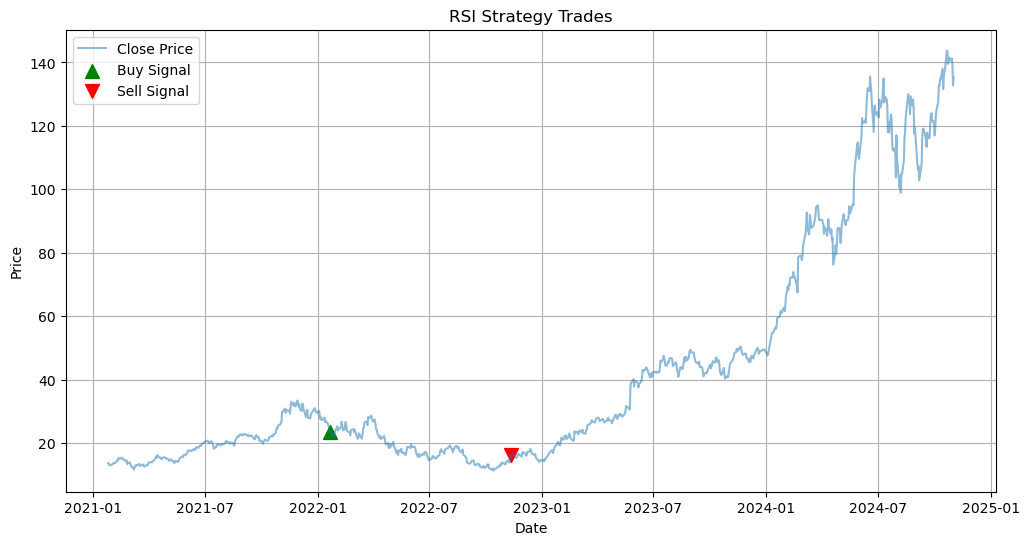

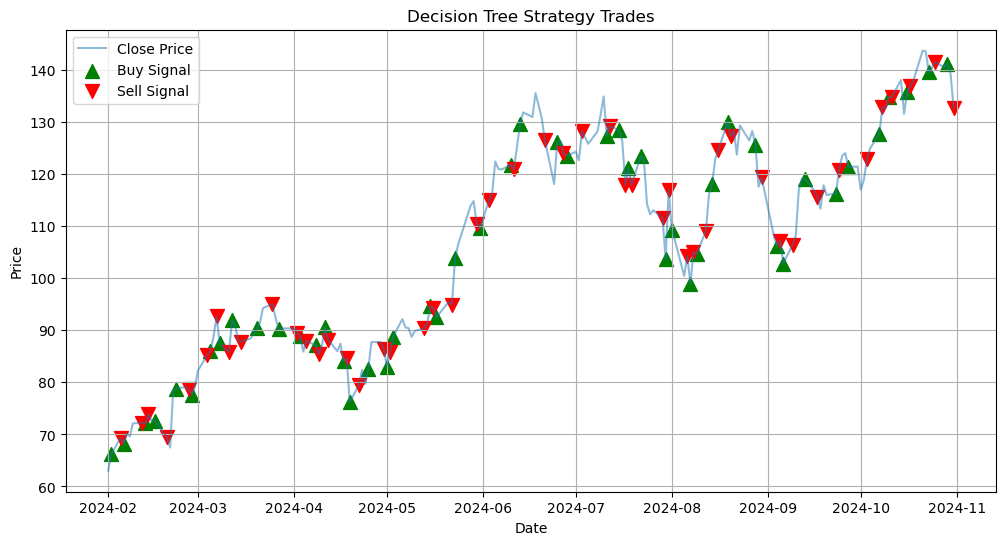

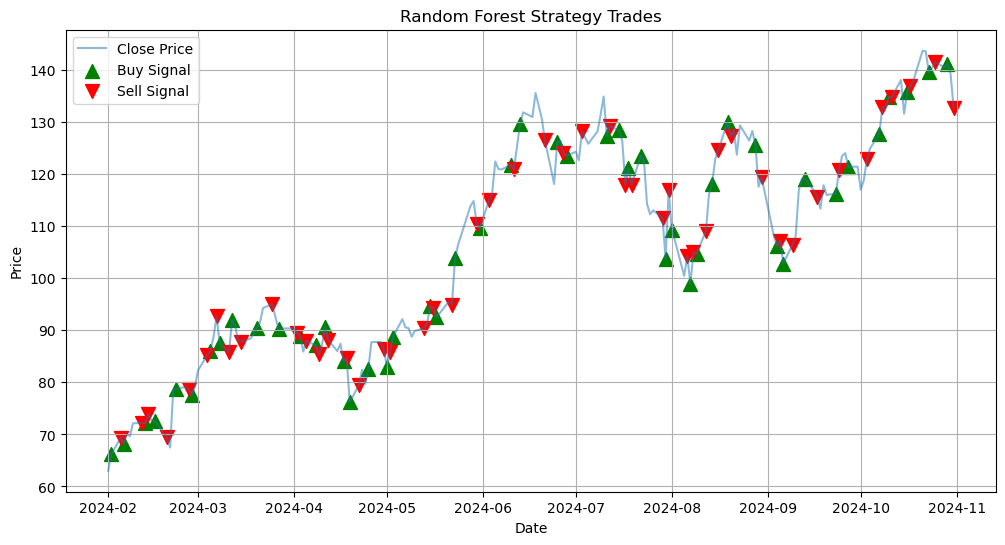

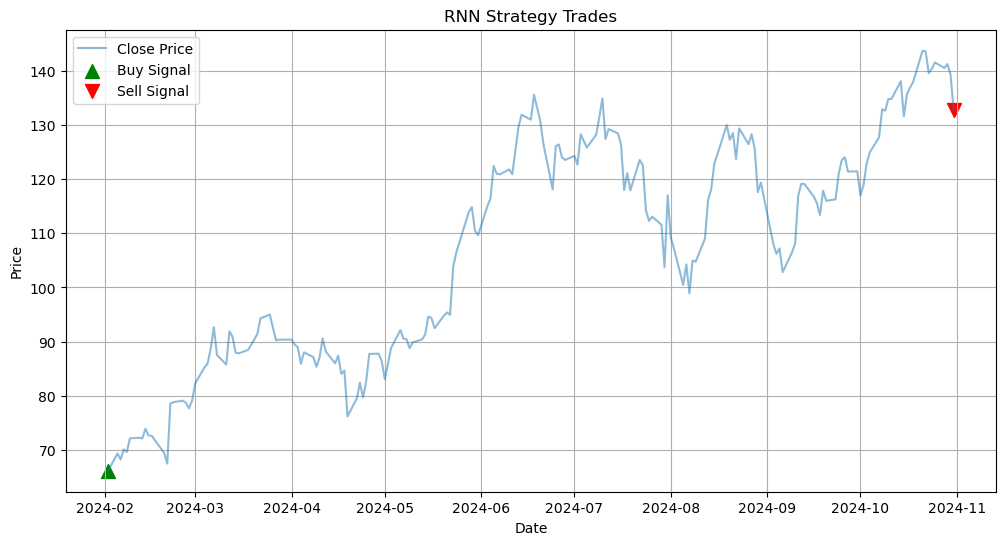

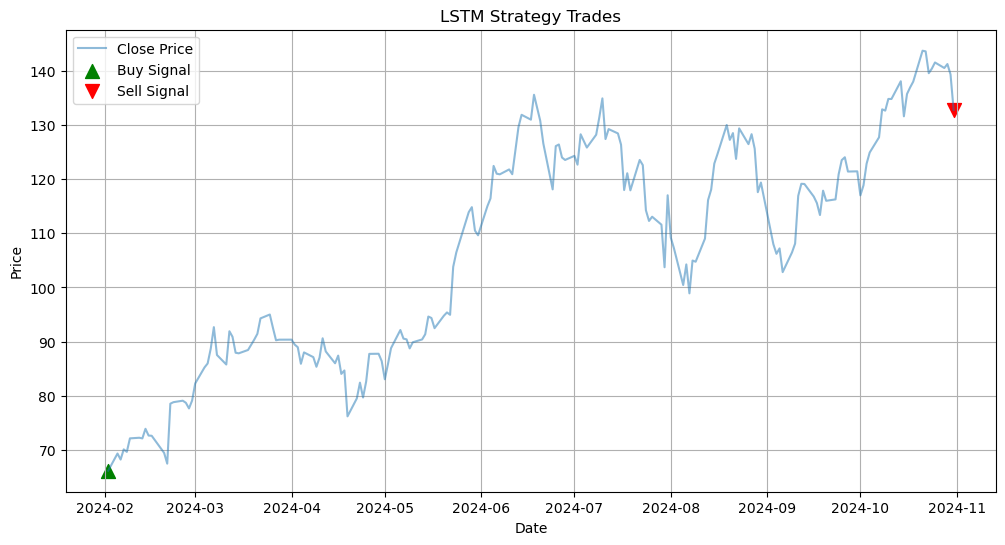

In [133]:

# 5. Visualize Results

def plot_strategy(trade_log, data, title):
    """
    Plots the trading signals on the price chart.
    """
    trade_df = pd.DataFrame(trade_log)
    plt.figure(figsize=(12, 6))
    plt.plot(data['Date'], data['Close'], label='Close Price', alpha=0.5)
    plt.scatter(trade_df[trade_df['Type'] == 'Buy']['Date'], trade_df[trade_df['Type'] == 'Buy']['Price'],
                label='Buy Signal', marker='^', color='green', s=100)
    plt.scatter(trade_df[trade_df['Type'] == 'Sell']['Date'], trade_df[trade_df['Type'] == 'Sell']['Price'],
                label='Sell Signal', marker='v', color='red', s=100)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot RSI Strategy
plot_strategy(rsi_strategy.trade_log, data, 'RSI Strategy Trades')

# Plot Decision Tree Strategy
dt_data = data[data['Date'].isin(dt_strategy.X_test_dates)]
plot_strategy(dt_strategy.trade_log, dt_data, 'Decision Tree Strategy Trades')

# Plot Random Forest Strategy
rf_data = data[data['Date'].isin(rf_strategy.X_test_dates)]
plot_strategy(rf_strategy.trade_log, rf_data, 'Random Forest Strategy Trades')

# Plot RNN Strategy
rnn_data = data[data['Date'].isin(rnn_strategy.X_test_dates)]
plot_strategy(rnn_strategy.trade_log, rnn_data, 'RNN Strategy Trades')

# Plot LSTM Strategy
lstm_data = data[data['Date'].isin(lstm_strategy.X_test_dates)]
plot_strategy(lstm_strategy.trade_log, lstm_data, 'LSTM Strategy Trades')